<a href="https://colab.research.google.com/github/christinaxliu/research/blob/main/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/RandomForest-XGBoost-Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import warnings
import os
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import plot_importance
from IPython import display
from IPython.display import Image
from six import StringIO
import pickle
from google.colab import drive

In [19]:
#pd.options.mode.copy_on_write = True
warnings.simplefilter('ignore')

In [20]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
nasa_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/NASA-EA-03-10-2024.csv'
nasa_exoplanets_data = pd.read_table(nasa_exoplanets_filename,
                                      skiprows=89,
                                      sep=',',
                                      header=None,
                                      index_col=None,
                                      names = ['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
                                                'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                                'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                                'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                                'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                                'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                                'ttv_flag', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim',
                                                'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim',
                                                'st_metratio', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'rastr', 'ra', 'decstr', 'dec',
                                                'sy_dist', 'sy_disterr1', 'sy_disterr2', 'sy_vmag', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_kmag', 'sy_kmagerr1', 'sy_kmagerr2',
                                                'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2',
                                                'placeholder1', 'placeholder2', 'raw_data_calc_orb_sma', 'placeholder3', 'raw_data_tsurf_k', 'raw_data_tsurf_c'],
                                      skipfooter=0,
                                      engine='python')

In [22]:
# Sanity check the first several rows of data to ensure data is read correctly
nasa_exoplanets_data.head()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,placeholder1,placeholder2,raw_data_calc_orb_sma,placeholder3,raw_data_tsurf_k,raw_data_tsurf_c
0,11 Com b,11 Com,2,1,Radial Velocity,2007,Xinglong Station,0,323.21000,0.06000,...,-0.346,4.44038,0.003848,-0.003848,NaN,NaN,1.178453,NaN,828.6423703,555.4923703
1,11 UMi b,11 UMi,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,0,516.21997,3.20000,...,-0.270,4.56216,0.003903,-0.003903,NaN,NaN,1.770837,NaN,924.7536086,651.6036086
2,14 And b,14 And,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,0,186.76000,0.11000,...,-0.240,4.91781,0.002826,-0.002826,NaN,NaN,0.774943,NaN,938.677434,665.527434
3,14 Her b,14 Her,1,2,Radial Velocity,2002,W. M. Keck Observatory,0,1765.03890,1.67709,...,-0.016,6.38300,0.000351,-0.000351,NaN,NaN,2.769856,NaN,153.7488424,-119.4011576
4,16 Cyg B b,16 Cyg B,3,1,Radial Velocity,1996,Multiple Observatories,0,798.50000,1.00000,...,-0.016,6.06428,0.000603,-0.000603,NaN,NaN,1.728217,NaN,235.9924243,-37.15757566


In [23]:
# Sanity check the last several rows of data to ensure data is read correctly.
nasa_exoplanets_data.tail()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,placeholder1,placeholder2,raw_data_calc_orb_sma,placeholder3,raw_data_tsurf_k,raw_data_tsurf_c
5590,ups And b,ups And,2,3,Radial Velocity,1996,Lick Observatory,0,4.617033,0.000023,...,-0.274,3.98687,0.008937,-0.008937,NaN,NaN,0.059224,NaN,1571.87763,1298.72763
5591,ups And c,ups And,2,3,Radial Velocity,1999,Multiple Observatories,0,241.258000,0.064000,...,-0.274,3.98687,0.008937,-0.008937,NaN,NaN,0.827770,NaN,420.4403392,147.2903392
5592,ups And d,ups And,2,3,Radial Velocity,1999,Multiple Observatories,0,1276.460000,0.570000,...,-0.274,3.98687,0.008937,-0.008937,NaN,NaN,2.513389,NaN,241.2898018,-31.86019816
5593,ups Leo b,ups Leo,1,1,Radial Velocity,2021,Okayama Astrophysical Observatory,0,385.200000,2.800000,...,-0.248,4.03040,0.008513,-0.008513,NaN,NaN,1.180734,NaN,741.7998759,468.6498759
5594,xi Aql b,xi Aql,1,1,Radial Velocity,2007,Okayama Astrophysical Observatory,0,136.970000,0.110000,...,-0.220,4.42501,0.003837,-0.003837,NaN,NaN,0.625471,NaN,1003.818109,730.6681086


In [24]:
# Get the statistics about the data
nasa_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595 entries, 0 to 5594
Data columns (total 90 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pl_name                5595 non-null   object 
 1   hostname               5595 non-null   object 
 2   sy_snum                5595 non-null   int64  
 3   sy_pnum                5595 non-null   int64  
 4   discoverymethod        5595 non-null   object 
 5   disc_year              5595 non-null   int64  
 6   disc_facility          5595 non-null   object 
 7   pl_controv_flag        5595 non-null   int64  
 8   pl_orbper              5346 non-null   float64
 9   pl_orbpererr1          4867 non-null   float64
 10  pl_orbpererr2          4867 non-null   float64
 11  pl_orbperlim           5346 non-null   float64
 12  pl_orbsmax             5298 non-null   float64
 13  pl_orbsmaxerr1         2693 non-null   float64
 14  pl_orbsmaxerr2         2693 non-null   float64
 15  pl_o

In [25]:
# Only selects exoplanets with pl_controv_flag == 0
nasa_exoplanets_data = nasa_exoplanets_data.loc[(nasa_exoplanets_data['pl_controv_flag'] == 0)]

In [26]:
nasa_exoplanets_data = nasa_exoplanets_data.loc[
    (~np.isnan(nasa_exoplanets_data['sy_snum'])) & (nasa_exoplanets_data['sy_snum'] == 1)
    & ~np.isnan(nasa_exoplanets_data['st_teff'])
    & ~np.isnan(nasa_exoplanets_data['st_rad'])
    & ~np.isnan(nasa_exoplanets_data['pl_orbsmax'])]

In [27]:
hwc_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/hwc-09-06-2024.csv'
hwc_exoplanets_data = pd.read_csv(hwc_exoplanets_filename)
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


In [28]:
hwc_exoplanets_data = hwc_exoplanets_data.loc[~np.isnan(hwc_exoplanets_data['P_HABITABLE'])]
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.1+ MB


In [29]:
exoplanets_data = pd.merge(nasa_exoplanets_data,
                           hwc_exoplanets_data[['P_HABITABLE']],
                           how="left",
                           left_on=nasa_exoplanets_data['pl_name'].str.lower(),
                           right_on=hwc_exoplanets_data['P_NAME'].str.lower())
exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 92 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key_0                  4575 non-null   object 
 1   pl_name                4575 non-null   object 
 2   hostname               4575 non-null   object 
 3   sy_snum                4575 non-null   int64  
 4   sy_pnum                4575 non-null   int64  
 5   discoverymethod        4575 non-null   object 
 6   disc_year              4575 non-null   int64  
 7   disc_facility          4575 non-null   object 
 8   pl_controv_flag        4575 non-null   int64  
 9   pl_orbper              4538 non-null   float64
 10  pl_orbpererr1          4081 non-null   float64
 11  pl_orbpererr2          4081 non-null   float64
 12  pl_orbperlim           4538 non-null   float64
 13  pl_orbsmax             4575 non-null   float64
 14  pl_orbsmaxerr1         2058 non-null   float64
 15  pl_o

In [30]:
exoplanets_data.to_csv('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/NasaJoinedWithHWCData-03-10-2024.csv')

In [31]:
# Drop data fields that are not relevant to the training
training_prep_data = exoplanets_data.drop(['key_0','pl_name', 'hostname', 'sy_snum',
                                            'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
                                            'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim',
                                            'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbperlim',
                                            'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                            'pl_radeerr1', 'pl_radeerr2', 'pl_radelim',
                                            'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                            'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim',
                                            'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                            'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                            'pl_insolerr1', 'pl_insolerr2', 'pl_insollim',
                                            'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                            'ttv_flag', 'st_tefferr1', 'st_tefferr2', 'st_tefflim',
                                            'st_raderr1', 'st_raderr2', 'st_radlim',
                                            'st_masserr1', 'st_masserr2', 'st_masslim',
                                            'st_meterr1', 'st_meterr2', 'st_metlim',
                                            'st_loggerr1', 'st_loggerr2', 'st_logglim',
                                            'rastr', 'decstr',
                                            'sy_disterr1', 'sy_disterr2', 'sy_vmagerr1', 'sy_vmagerr2',
                                            'sy_kmagerr1', 'sy_kmagerr2', 'sy_gaiamagerr1', 'sy_gaiamagerr2',
                                            'placeholder1', 'placeholder2', 'raw_data_calc_orb_sma',
                                            'placeholder3', 'raw_data_tsurf_k', 'raw_data_tsurf_c'],
                                          axis = 1)

# Drop data fields that are duplicate to others
training_prep_data = training_prep_data.drop(['pl_bmassj', 'pl_radj'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4575 non-null   int64  
 1   pl_orbper     4538 non-null   float64
 2   pl_orbsmax    4575 non-null   float64
 3   pl_rade       4567 non-null   float64
 4   pl_bmasse     4557 non-null   float64
 5   pl_bmassprov  4575 non-null   object 
 6   pl_orbeccen   4268 non-null   float64
 7   pl_insol      3557 non-null   float64
 8   pl_eqt        3717 non-null   float64
 9   st_spectype   1564 non-null   object 
 10  st_teff       4575 non-null   float64
 11  st_rad        4575 non-null   float64
 12  st_mass       4574 non-null   float64
 13  st_met        4422 non-null   float64
 14  st_metratio   4406 non-null   object 
 15  st_logg       4568 non-null   float64
 16  ra            4575 non-null   float64
 17  dec           4575 non-null   float64
 18  sy_dist       4560 non-null 

In [32]:
training_prep_data['P_HABITABLE'].value_counts()

,count
P_HABITABLE,
0,4520
2,31
1,24


In [33]:
training_prep_data['hz_label'] = training_prep_data['P_HABITABLE']
training_prep_data.loc[training_prep_data['hz_label'] == 2, 'hz_label'] = 1
training_prep_data['hz_label'].value_counts()

,count
hz_label,
0,4520
1,55


In [34]:
training_prep_data = training_prep_data.drop(['P_HABITABLE'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4575 non-null   int64  
 1   pl_orbper     4538 non-null   float64
 2   pl_orbsmax    4575 non-null   float64
 3   pl_rade       4567 non-null   float64
 4   pl_bmasse     4557 non-null   float64
 5   pl_bmassprov  4575 non-null   object 
 6   pl_orbeccen   4268 non-null   float64
 7   pl_insol      3557 non-null   float64
 8   pl_eqt        3717 non-null   float64
 9   st_spectype   1564 non-null   object 
 10  st_teff       4575 non-null   float64
 11  st_rad        4575 non-null   float64
 12  st_mass       4574 non-null   float64
 13  st_met        4422 non-null   float64
 14  st_metratio   4406 non-null   object 
 15  st_logg       4568 non-null   float64
 16  ra            4575 non-null   float64
 17  dec           4575 non-null   float64
 18  sy_dist       4560 non-null 

In [35]:
# Calculate the missing value % for each data field, then sort data fields by the missing value percentages
missing_value_count = training_prep_data.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((training_prep_data.isnull().sum() / training_prep_data.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

,Count,%
st_spectype,3011,65.814208
pl_insol,1018,22.251366
pl_eqt,858,18.754098
pl_orbeccen,307,6.710383
st_metratio,169,3.693989
st_met,153,3.344262
pl_orbper,37,0.808743
sy_gaiamag,33,0.721311
pl_bmasse,18,0.393443
sy_dist,15,0.327869


In [36]:
# Drop off data fields with missing value % >= 25%
training_prep_data = training_prep_data.drop(['st_spectype'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4575 non-null   int64  
 1   pl_orbper     4538 non-null   float64
 2   pl_orbsmax    4575 non-null   float64
 3   pl_rade       4567 non-null   float64
 4   pl_bmasse     4557 non-null   float64
 5   pl_bmassprov  4575 non-null   object 
 6   pl_orbeccen   4268 non-null   float64
 7   pl_insol      3557 non-null   float64
 8   pl_eqt        3717 non-null   float64
 9   st_teff       4575 non-null   float64
 10  st_rad        4575 non-null   float64
 11  st_mass       4574 non-null   float64
 12  st_met        4422 non-null   float64
 13  st_metratio   4406 non-null   object 
 14  st_logg       4568 non-null   float64
 15  ra            4575 non-null   float64
 16  dec           4575 non-null   float64
 17  sy_dist       4560 non-null   float64
 18  sy_vmag       4568 non-null 

In [37]:
training_prep_data.select_dtypes(include = ['object']).columns

Index(['pl_bmassprov', 'st_metratio'], dtype='object')

In [38]:
# Calculate the missing value % for the categorial data field, then sort categorial data fields by the missing value percentages
categorial_data_fields = training_prep_data.select_dtypes(include = ['object'])
missing_value_count = categorial_data_fields.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((categorial_data_fields.isnull().sum() / categorial_data_fields.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

,Count,%
st_metratio,169,3.693989
pl_bmassprov,0,0.000000


In [39]:
# Fill in the missing values in categorical data fields with mode
training_prep_data['st_metratio'] = training_prep_data['st_metratio'].fillna(training_prep_data['st_metratio'].mode()[0])

In [40]:
# Encode categorical data fields to numeric values with Label Encoder
encoders = {}
for column in training_prep_data.select_dtypes(include = ['object']).columns:
    encoders[column] = LabelEncoder()
    training_prep_data[column] = encoders[column].fit_transform(training_prep_data[column])
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4575 non-null   int64  
 1   pl_orbper     4538 non-null   float64
 2   pl_orbsmax    4575 non-null   float64
 3   pl_rade       4567 non-null   float64
 4   pl_bmasse     4557 non-null   float64
 5   pl_bmassprov  4575 non-null   int64  
 6   pl_orbeccen   4268 non-null   float64
 7   pl_insol      3557 non-null   float64
 8   pl_eqt        3717 non-null   float64
 9   st_teff       4575 non-null   float64
 10  st_rad        4575 non-null   float64
 11  st_mass       4574 non-null   float64
 12  st_met        4422 non-null   float64
 13  st_metratio   4575 non-null   int64  
 14  st_logg       4568 non-null   float64
 15  ra            4575 non-null   float64
 16  dec           4575 non-null   float64
 17  sy_dist       4560 non-null   float64
 18  sy_vmag       4568 non-null 

In [41]:
training_prep_data['pl_bmassprov'].value_counts()

,count
pl_bmassprov,
0,2581
1,1295
3,684
2,15


In [42]:
training_prep_data['st_metratio'].value_counts()

,count
st_metratio,
0,4067
1,497
3,7
2,4


In [43]:
# Fill in the missing values for the numeric data fields with Multivariate Imputation by Chained Equation (MICE) imputation
# https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00313-w
imputed_training_prep_data = training_prep_data.copy(deep = True)
mice_imputer = IterativeImputer()
imputed_training_prep_data.iloc[:, :] = mice_imputer.fit_transform(training_prep_data)
imputed_training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4575 non-null   int64  
 1   pl_orbper     4575 non-null   float64
 2   pl_orbsmax    4575 non-null   float64
 3   pl_rade       4575 non-null   float64
 4   pl_bmasse     4575 non-null   float64
 5   pl_bmassprov  4575 non-null   int64  
 6   pl_orbeccen   4575 non-null   float64
 7   pl_insol      4575 non-null   float64
 8   pl_eqt        4575 non-null   float64
 9   st_teff       4575 non-null   float64
 10  st_rad        4575 non-null   float64
 11  st_mass       4575 non-null   float64
 12  st_met        4575 non-null   float64
 13  st_metratio   4575 non-null   int64  
 14  st_logg       4575 non-null   float64
 15  ra            4575 non-null   float64
 16  dec           4575 non-null   float64
 17  sy_dist       4575 non-null   float64
 18  sy_vmag       4575 non-null 

In [44]:
habitability_status_counts = Counter(imputed_training_prep_data['hz_label'])
for habitability_status_label, habitability_status_count in habitability_status_counts.items():
    habitability_status_percentage = (habitability_status_count / len(imputed_training_prep_data['hz_label'])) * 100
    print('hz_label=%d, count=%d (%.3f%%)' % (habitability_status_label, habitability_status_count, habitability_status_percentage))

hz_label=0, count=4520 (98.798%)
hz_label=1, count=55 (1.202%)


In [45]:
features_to_balance, labels_to_balance = imputed_training_prep_data.drop(['hz_label'], axis = 1), imputed_training_prep_data.hz_label

smoteenn = SMOTEENN(random_state=0)
balanced_features, balanced_labels = smoteenn.fit_resample(features_to_balance, labels_to_balance)

habitability_status_counts = Counter(balanced_labels)
for habitability_status_label, habitability_status_count in habitability_status_counts.items():
    habitability_status_percentage = (habitability_status_count / len(balanced_labels)) * 100
    print('hz_label=%d, count=%d (%.3f%%)' % (habitability_status_label, habitability_status_count, habitability_status_percentage))

hz_label=0, count=4423 (49.563%)
hz_label=1, count=4501 (50.437%)


In [46]:
balanced_training_prep_data = balanced_features
balanced_training_prep_data['hz_label'] = balanced_labels
balanced_training_prep_data.shape

(8924, 22)

<Axes: >

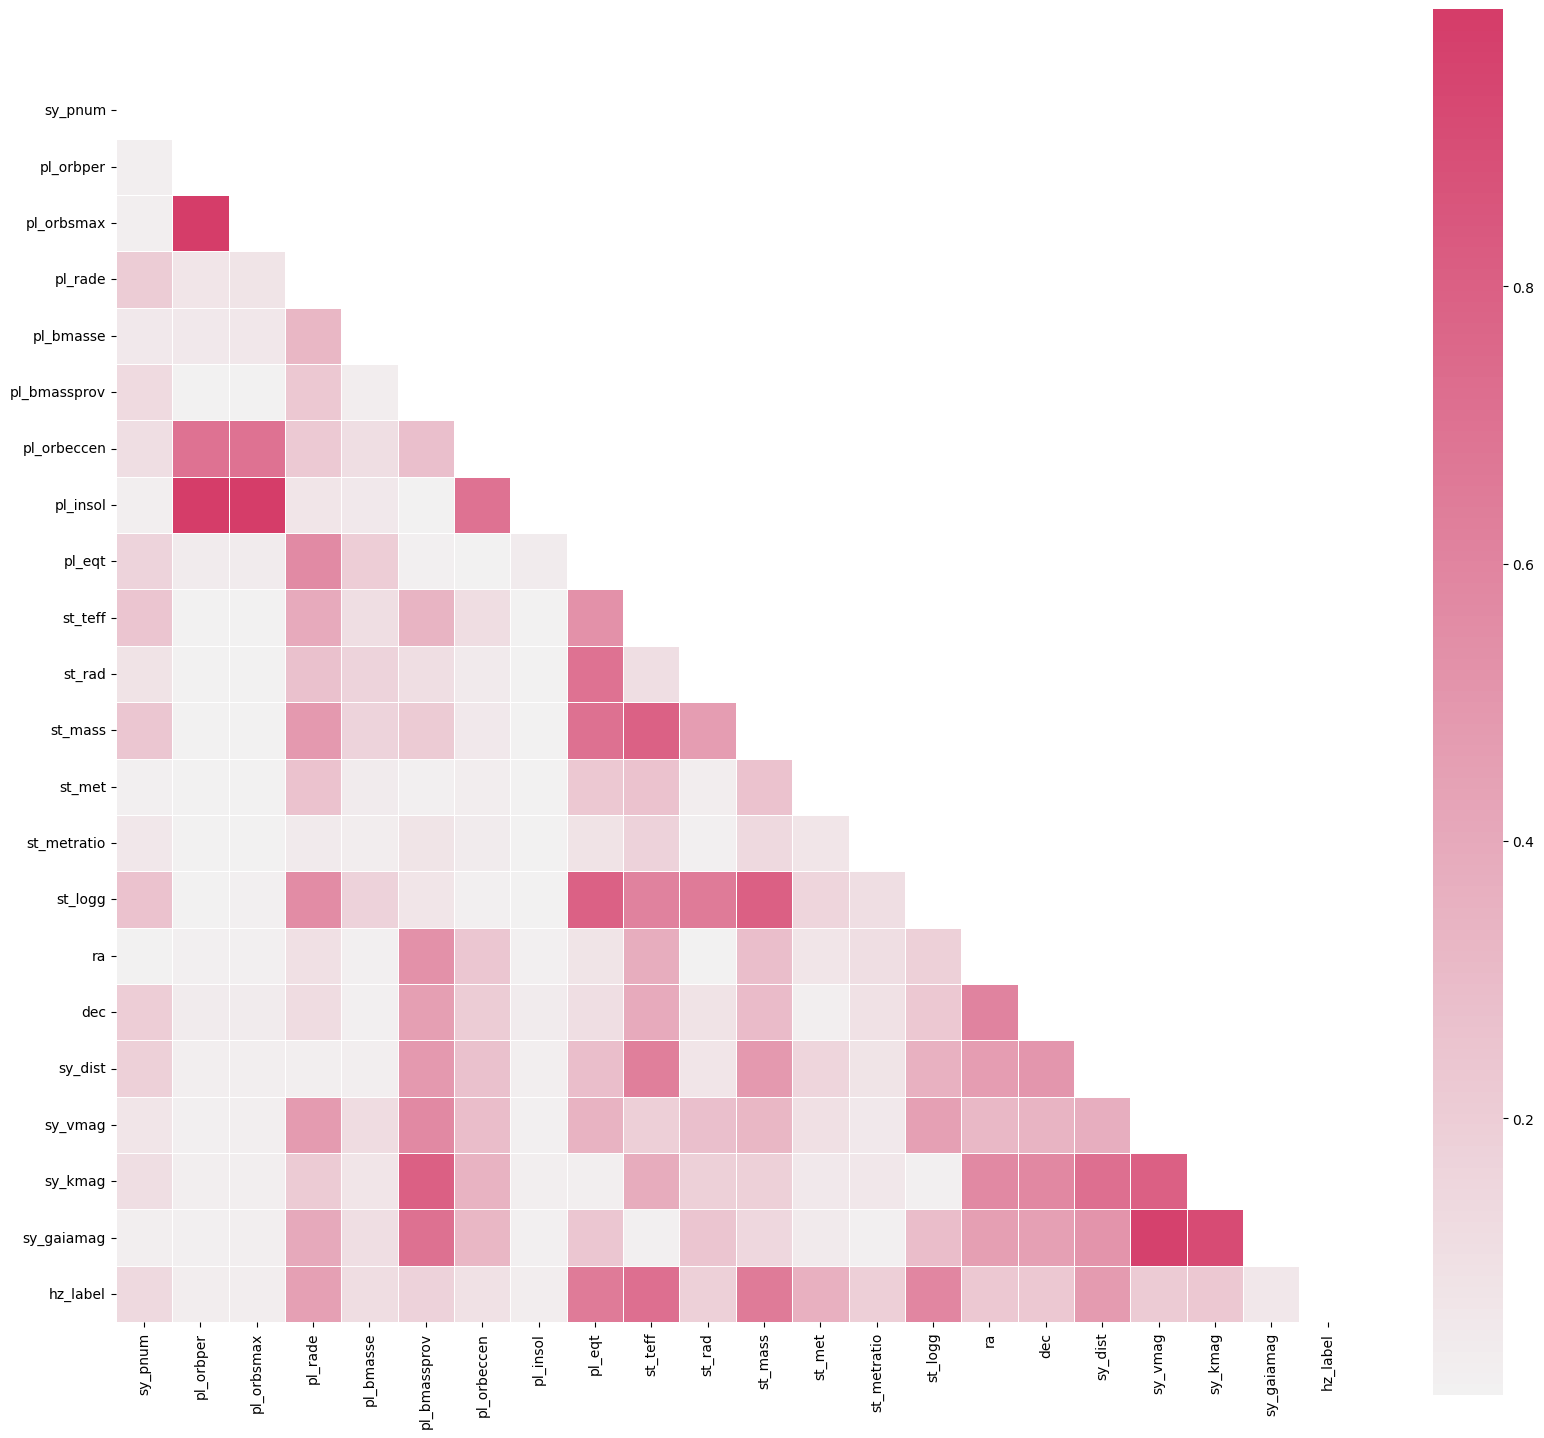

In [47]:
correlation_matrix = balanced_training_prep_data.corr().abs()

mask = np.triu(np.ones_like(correlation_matrix, dtype = np.bool_))
f, ax = plt.subplots(figsize = (20, 20))
cmap = sns.diverging_palette(255, 0, as_cmap = True)
sns.heatmap(correlation_matrix,
            mask = mask,
            cmap = cmap,
            vmax = None,
            center = 0,
            square = True,
            annot = False,
            linewidths = .5,
            cbar_kws = {"shrink": 0.9})

In [48]:
# Drop highly correlated data fields
preprocessed_training_data = balanced_training_prep_data.drop(['pl_orbeccen', 'pl_insol', 'sy_gaiamag'], axis = 1)

In [49]:
preprocessed_training_data = preprocessed_training_data.drop(['pl_eqt'], axis = 1)
features = preprocessed_training_data.drop('hz_label', axis = 1)
labels = preprocessed_training_data['hz_label']
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8924 entries, 0 to 8923
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       8924 non-null   int64  
 1   pl_orbper     8924 non-null   float64
 2   pl_orbsmax    8924 non-null   float64
 3   pl_rade       8924 non-null   float64
 4   pl_bmasse     8924 non-null   float64
 5   pl_bmassprov  8924 non-null   int64  
 6   st_teff       8924 non-null   float64
 7   st_rad        8924 non-null   float64
 8   st_mass       8924 non-null   float64
 9   st_met        8924 non-null   float64
 10  st_metratio   8924 non-null   int64  
 11  st_logg       8924 non-null   float64
 12  ra            8924 non-null   float64
 13  dec           8924 non-null   float64
 14  sy_dist       8924 non-null   float64
 15  sy_vmag       8924 non-null   float64
 16  sy_kmag       8924 non-null   float64
dtypes: float64(14), int64(3)
memory usage: 1.2 MB


In [50]:
# Split the preprocessed_training_data into train and test subsets
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.45,
                                                                            stratify=labels,
                                                                            random_state=42)

print(f"features_train dimensions: {features_train.shape}")
print(f"features_test dimensions: {features_test.shape}")
print(f"labels_train dimensions: {labels_train.shape}")
print(f"labels_test dimensions: {labels_test.shape}")

features_train dimensions: (4908, 17)
features_test dimensions: (4016, 17)
labels_train dimensions: (4908,)
labels_test dimensions: (4016,)


In [51]:
minMaxScaler = MinMaxScaler()
features_train = minMaxScaler.fit_transform(features_train)
features_test = minMaxScaler.fit_transform(features_test)

In [52]:
def plot_confusion_matrix(labels, predictions):
    # Create a confusion matrix that compares the prediction results against the labels
    confusionMatrix = confusion_matrix(labels, predictions)

    # Create a dataframe for the confusion matrix for plotting
    confusionMatrixDf = pd.DataFrame(confusionMatrix,
                                     index = ['Non-Habitable', 'Habitable'],
                                     columns = ['Non-Habitable', 'Habitable'])

    # Plot the confusion matrix
    plt.figure(figsize = (5,4))
    sns.heatmap(confusionMatrixDf, annot = True)
    plt.title('Habitability Confusion Matrix')
    plt.ylabel('Label Values')
    plt.xlabel('Predicted Values')
    plt.show()

    return confusionMatrix

In [41]:
def search_optimal_params_random_forest(features,
                                        labels,
                                        cross_validation_rounds,
                                        split_test_size,
                                        split_stratify,
                                        split_random_state):
    print(f"Searching the optimal hyper parameters for Random Forest classifier...\n");
    minMaxScaler = MinMaxScaler()

    best_accuracy = 0
    best_n_estimators = 1
    best_criterion = 'gini'
    best_max_depth = 1
    best_max_features = 'log2'
    best_max_leaf_nodes = 1

    for n_estimators in range(1, 8, 1):
        for criterion in ['gini', 'entropy', 'log_loss']:
            for max_depth in range(1, 12, 1):
                for max_features in ['log2', 'sqrt']:
                    for max_leaf_nodes in range(2, 12, 1):
                        accuracy_sum = 0
                        for round in range(cross_validation_rounds):
                            features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                                        labels,
                                                                                                        test_size=split_test_size,
                                                                                                        stratify=split_stratify,
                                                                                                        random_state=split_random_state,
                                                                                                        shuffle=True)
                            features_train = minMaxScaler.fit_transform(features_train)
                            features_test = minMaxScaler.fit_transform(features_test)
                            random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                                                              criterion=criterion,
                                                                              max_depth=max_depth,
                                                                              max_features=max_features,
                                                                              max_leaf_nodes=max_leaf_nodes,
                                                                              random_state=0)
                            random_forest_classifier.fit(features_train, labels_train)

                            # Predict the samples in the test subset
                            random_forest_classifier_predictions = random_forest_classifier.predict(features_test)

                            # Plot the confusion matrix and print out the classification evaluation report
                            random_forest_classifier_accuracy = accuracy_score(labels_test, random_forest_classifier_predictions)
                            accuracy_sum += random_forest_classifier_accuracy
                        avg_accuracy = accuracy_sum / cross_validation_rounds
                        if avg_accuracy > best_accuracy:
                             best_accuracy = avg_accuracy
                             best_n_estimators = n_estimators
                             best_criterion = criterion,
                             best_max_depth = max_depth,
                             best_max_features = max_features,
                             best_max_leaf_nodes = max_leaf_nodes
                             print(f"Found a better avg accuracy at: {best_accuracy} - n_estimators: {best_n_estimators}, criterion: {best_criterion}, max_depth: {best_max_depth}, max_features: {best_max_features}, max_leaf_nodes: {best_max_leaf_nodes}")

search_optimal_params_random_forest(features=features,
                                    labels=labels,
                                    cross_validation_rounds=10,
                                    split_test_size=0.45,
                                    split_stratify=labels,
                                    split_random_state=42)

Searching the optimal hyper parameters for Random Forest classifier...

Found a better avg accuracy at: 0.7064243027888446 - n_estimators: 1, criterion: ('gini',), max_depth: (1,), max_features: ('log2',), max_leaf_nodes: 2
Found a better avg accuracy at: 0.7796314741035857 - n_estimators: 1, criterion: ('gini',), max_depth: (3,), max_features: ('log2',), max_leaf_nodes: 5
Found a better avg accuracy at: 0.836902390438247 - n_estimators: 1, criterion: ('gini',), max_depth: (3,), max_features: ('log2',), max_leaf_nodes: 6
Found a better avg accuracy at: 0.8398904382470119 - n_estimators: 1, criterion: ('gini',), max_depth: (4,), max_features: ('log2',), max_leaf_nodes: 7
Found a better avg accuracy at: 0.8510956175298805 - n_estimators: 1, criterion: ('gini',), max_depth: (4,), max_features: ('log2',), max_leaf_nodes: 11
Found a better avg accuracy at: 0.8553286852589641 - n_estimators: 1, criterion: ('entropy',), max_depth: (5,), max_features: ('log2',), max_leaf_nodes: 10
Found a bett

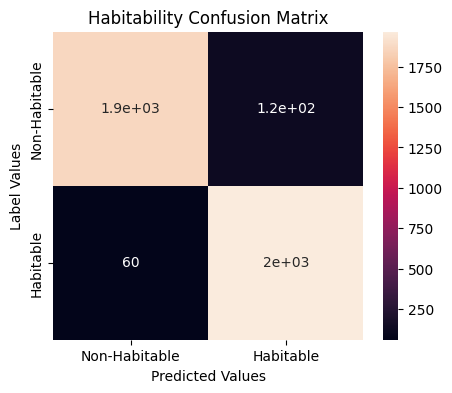

Random Forest Classififier - Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1990
           1       0.94      0.97      0.96      2026

    accuracy                           0.95      4016
   macro avg       0.95      0.95      0.95      4016
weighted avg       0.95      0.95      0.95      4016



In [53]:
# Train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators = 6,
                                                  criterion = 'gini',
                                                  max_depth = 7,
                                                  max_features = 'log2',
                                                  max_leaf_nodes = 11,
                                                  random_state = 0)
random_forest_classifier.fit(features_train, labels_train)

# Predict the samples in the test subset
random_forest_classifier_predictions = random_forest_classifier.predict(features_test)

# Plot the confusion matrix and print out the classification evaluation report
random_forest_classifier_accuracy = accuracy_score(labels_test, random_forest_classifier_predictions)
random_forest_classifier_confusion_matrix = plot_confusion_matrix(labels_test, random_forest_classifier_predictions)
print(f"Random Forest Classififier - Classification Report:\n")
print(classification_report(labels_test, random_forest_classifier_predictions))

,Feature Importance
st_rad: Stellar Radius [Solar Radius],0.274462
st_teff: Stellar Effective Temperature [K],0.212594
st_logg: Stellar Surface Gravity [log10(cm/s**2)],0.136978
pl_orbsmax: Planet Orbit Semi-Major Axis [au],0.132699
pl_rade: Planet Radius [Earth Radius],0.073394
sy_dist: Distance to the Planetary System [pc],0.062292
pl_bmasse: Planet Mass or Mass*sin(i) [Earth Mass],0.043432
dec: Declination of the Planetary System [decimal],0.027246
st_met: Stellar Metallicity [dex],0.010323
st_mass: Stellar Mass [Solar mass],0.008836


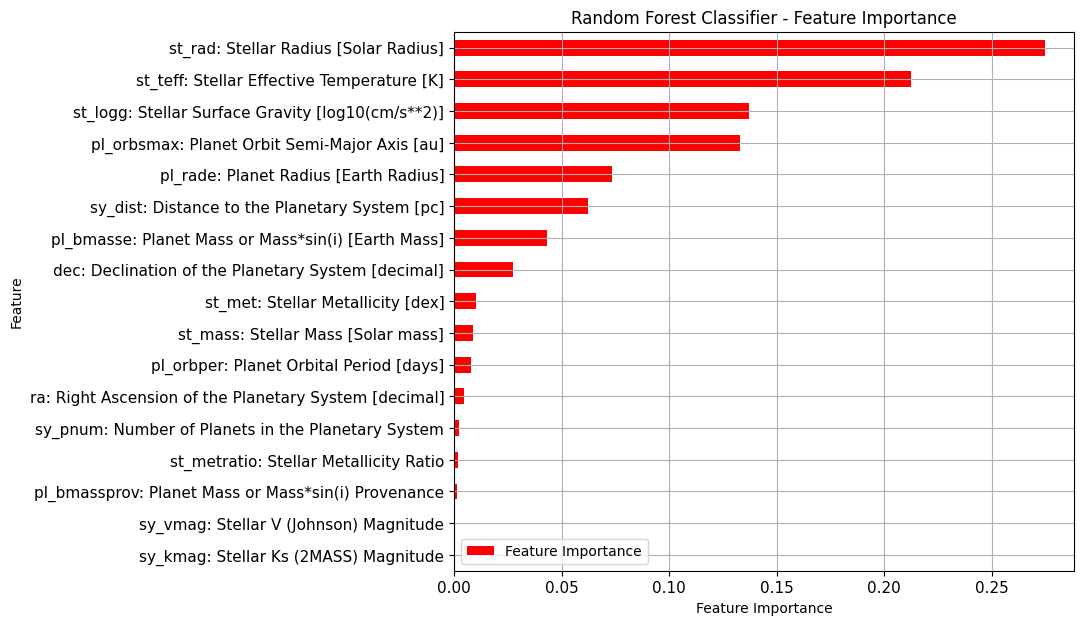

In [54]:
# Feature names
feature_columns = [
    'sy_pnum: Number of Planets in the Planetary System',
    'pl_orbper: Planet Orbital Period [days]',
    'pl_orbsmax: Planet Orbit Semi-Major Axis [au]',
    'pl_rade: Planet Radius [Earth Radius]',
    'pl_bmasse: Planet Mass or Mass*sin(i) [Earth Mass]',
    'pl_bmassprov: Planet Mass or Mass*sin(i) Provenance',
    'st_teff: Stellar Effective Temperature [K]',
    'st_rad: Stellar Radius [Solar Radius]',
    'st_mass: Stellar Mass [Solar mass]',
    'st_met: Stellar Metallicity [dex]',
    'st_metratio: Stellar Metallicity Ratio',
    'st_logg: Stellar Surface Gravity [log10(cm/s**2)]',
    'ra: Right Ascension of the Planetary System [decimal]',
    'dec: Declination of the Planetary System [decimal]',
    'sy_dist: Distance to the Planetary System [pc]',
    'sy_vmag: Stellar V (Johnson) Magnitude',
    'sy_kmag: Stellar Ks (2MASS) Magnitude'
]

# Calculate and plot feature importance
feature_importances = pd.DataFrame(data=random_forest_classifier.feature_importances_,
                                   index=feature_columns,
                                   columns=["Feature Importance"])
cmap = cm.get_cmap('hsv')

feature_importances.sort_values(by='Feature Importance', ascending=True, inplace=True)
feature_importances.plot(kind='barh',
                         figsize=(8,7),
                         title='Random Forest Classifier - Feature Importance',
                         xlabel='Feature Importance',
                         ylabel='Feature',
                         fontsize=11,
                         cmap=cmap,
                         grid=True)

feature_importances.sort_values(by='Feature Importance', ascending=False, inplace=True)
feature_importances

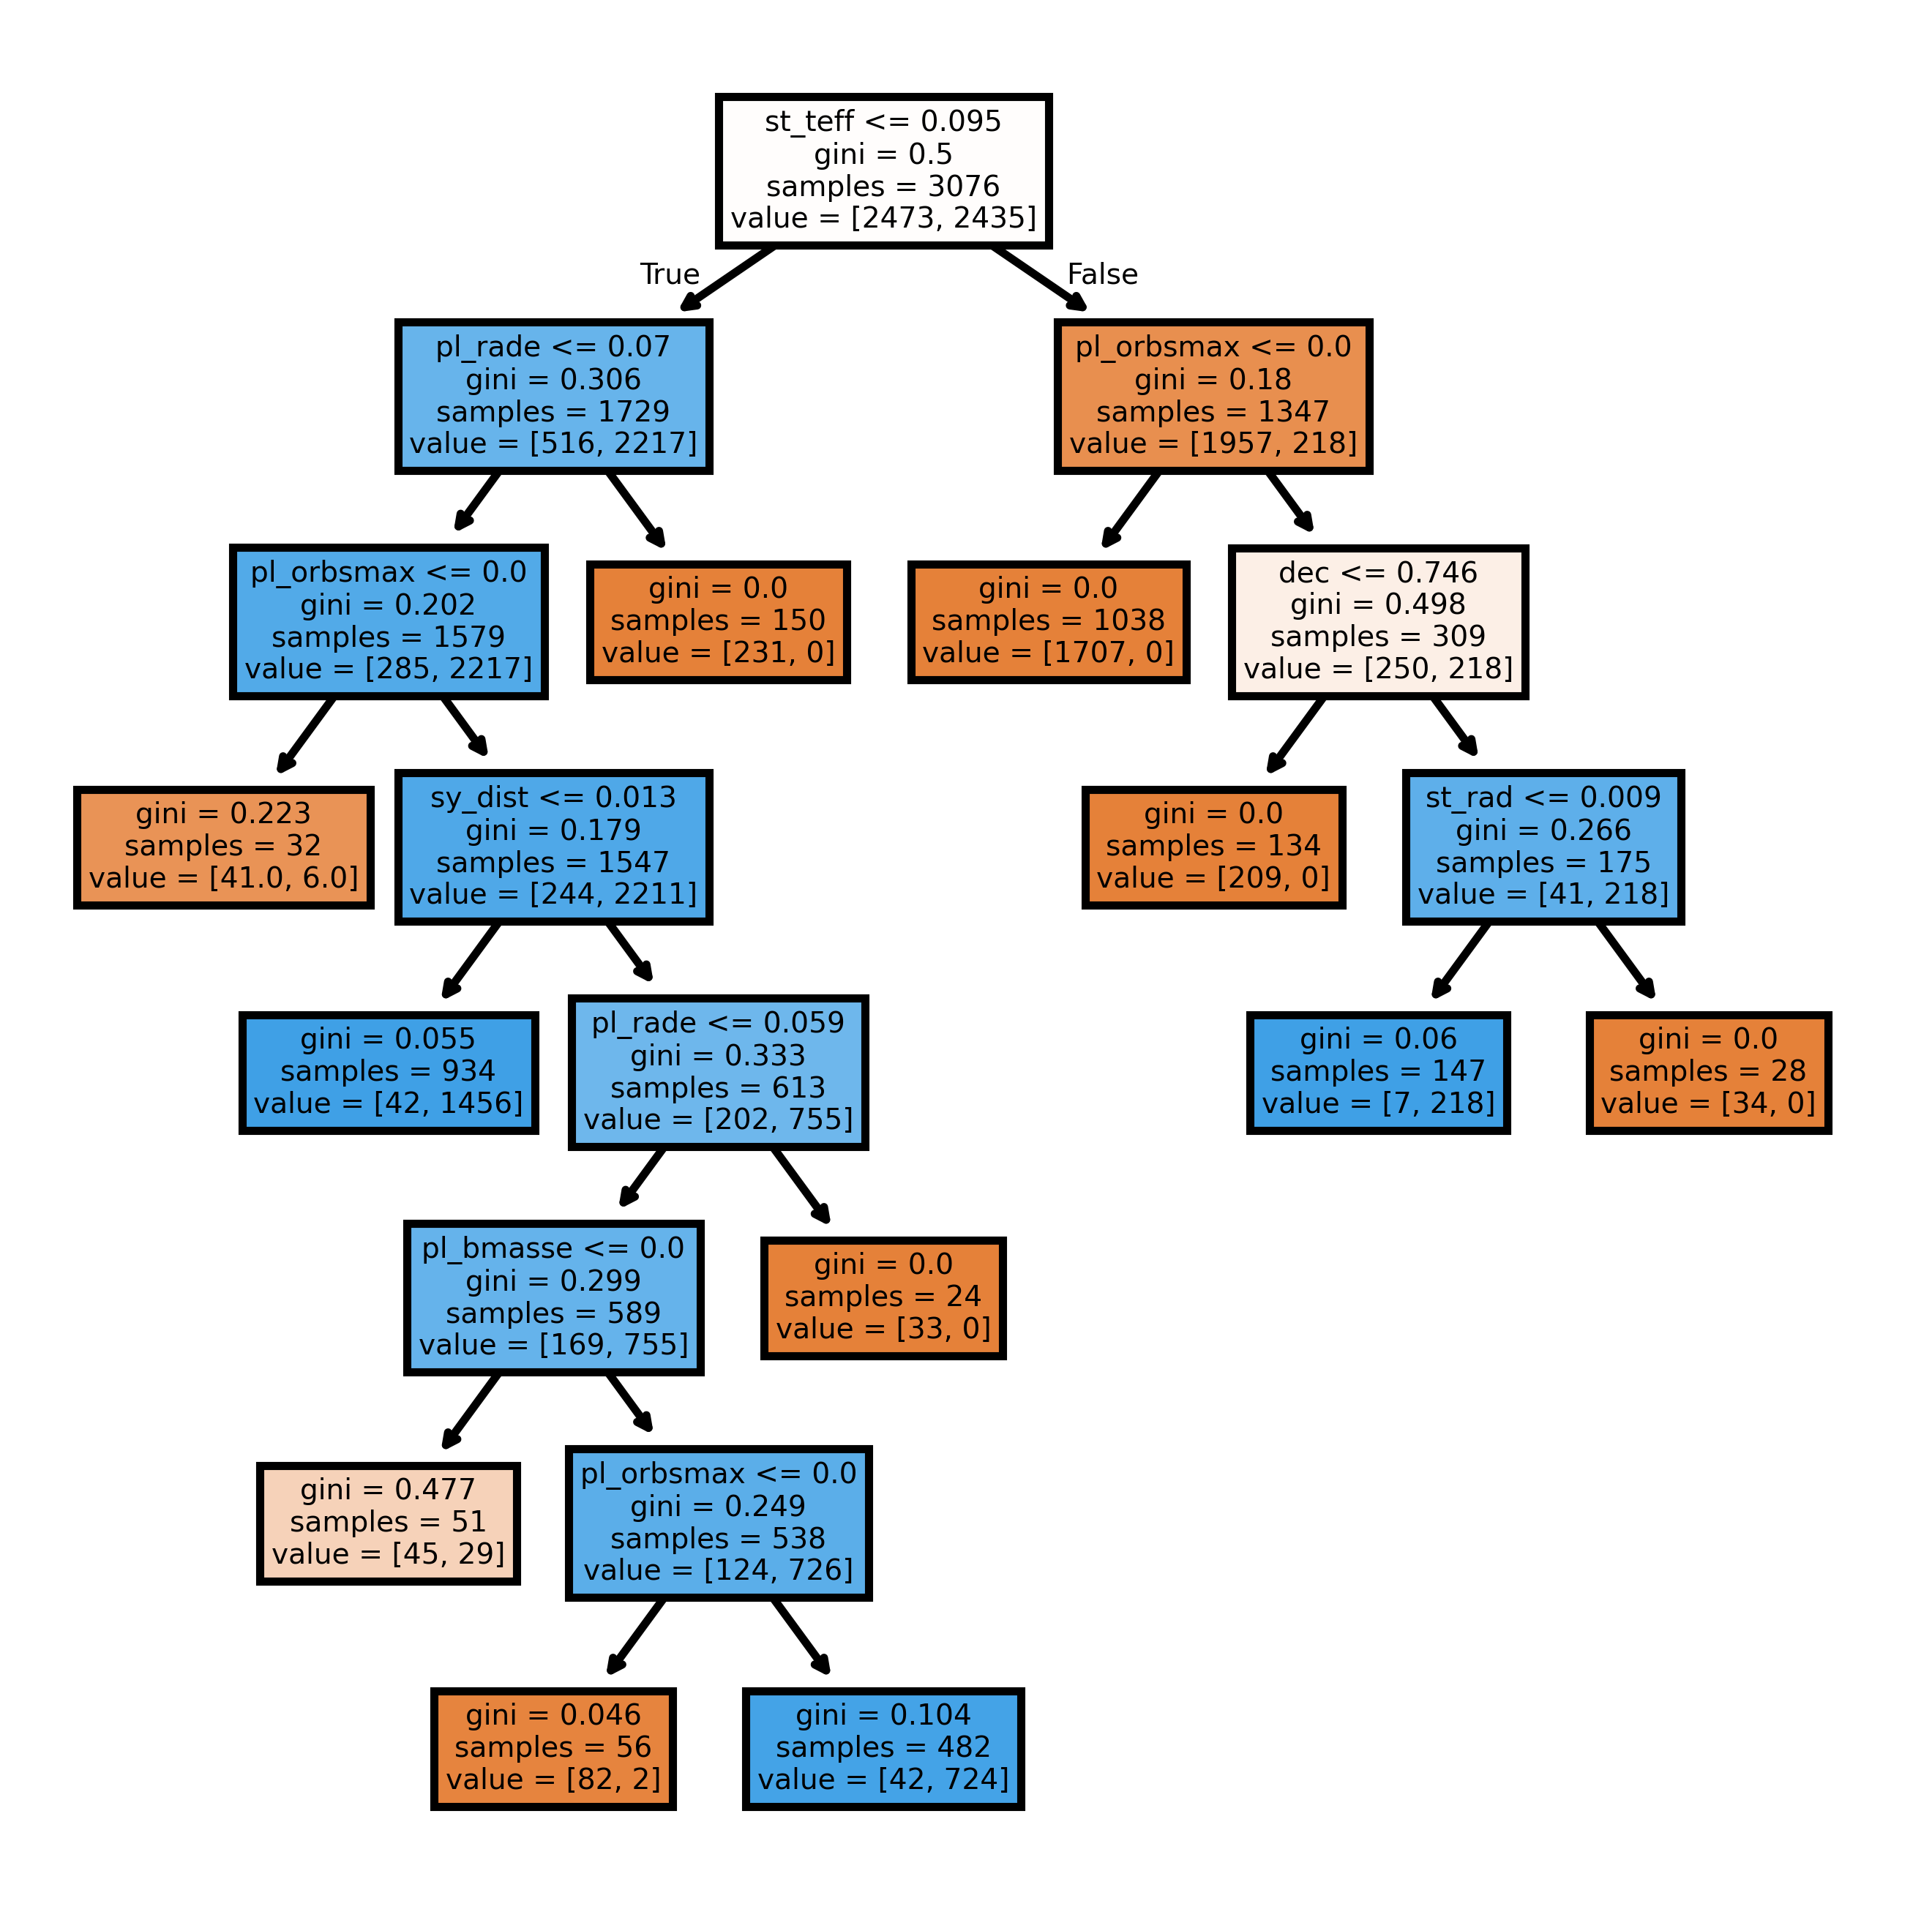

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi=800)
tree.plot_tree(random_forest_classifier.estimators_[3],
               feature_names=features.columns,
               filled=True);
fig.savefig('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/random_forest_individual_tree.png')

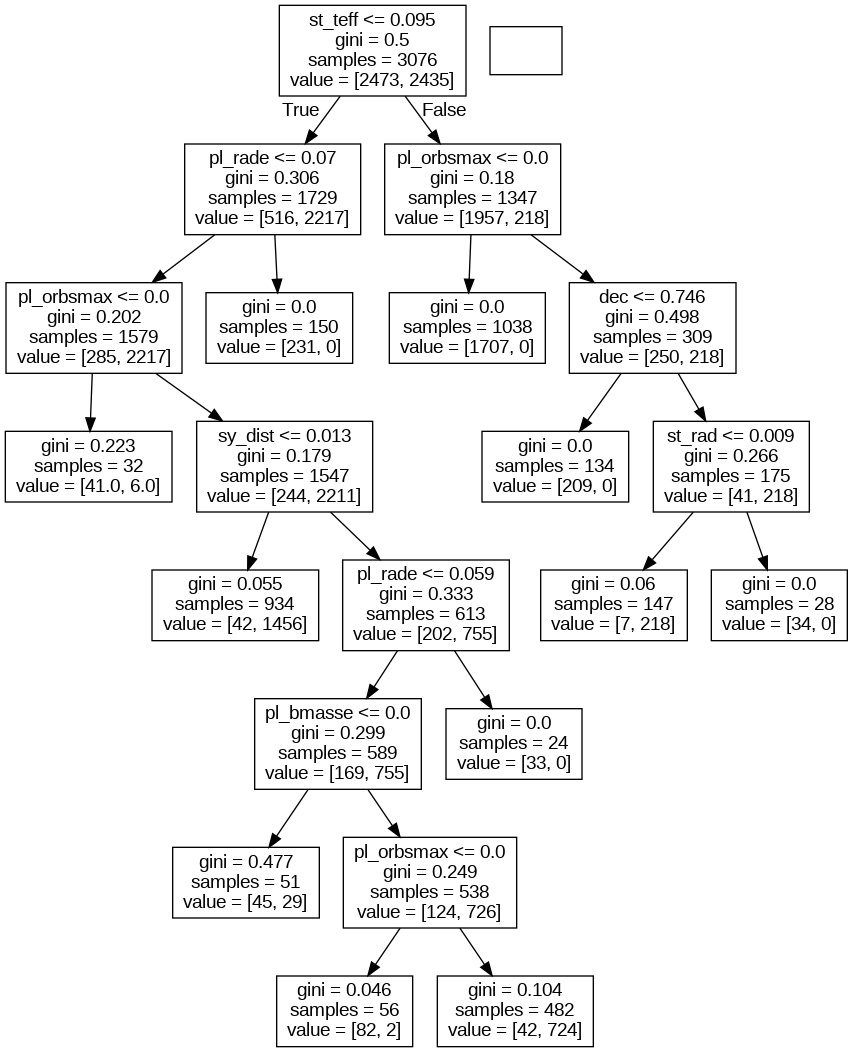

In [56]:
dot_data = StringIO()
export_graphviz(random_forest_classifier.estimators_[3],
                feature_names=features.columns,
                out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [60]:
# Save the Random Forest classifier model
random_forest_pickle = open('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/random_forest_classifier', 'wb')
pickle.dump(random_forest_classifier, random_forest_pickle)
random_forest_pickle.close()

In [61]:
# Load the Random Forest classifier model and test with test data
loaded_random_forest_classifier = pickle.load(open('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/random_forest_classifier', 'rb'))
pred_results = loaded_random_forest_classifier.predict(features_test)
pred_results

array([1, 1, 0, ..., 0, 0, 0])

In [47]:
def search_optimal_params_xgboost(features,
                                  labels,
                                  cross_validation_rounds,
                                  split_test_size,
                                  split_stratify,
                                  split_random_state):
    print(f"Searching the optimal hyper parameters for XGBoost classifier...\n");
    minMaxScaler = MinMaxScaler()

    best_accuracy = 0
    best_n_estimators = 1
    best_max_depth = 1
    best_learning_rate = 1
    best_objective = 'binary:logistic'
    best_eval_metric = 'logloss'
    best_max_leaves = 1

    for n_estimators in range(1, 12, 1):
        for max_depth in range(1, 12, 1):
            for learning_rate in range(1, 10, 1):
                for objective in ['binary:logistic', 'binary:hinge']:
                    for eval_metric in ['logloss', 'rmse', 'error', 'auc']:
                        for max_leaves in range(1, 12, 1):
                            accuracy_sum = 0
                            for round in range(cross_validation_rounds):
                                features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                                            labels,
                                                                                                            test_size=split_test_size,
                                                                                                            stratify=split_stratify,
                                                                                                            random_state=split_random_state,
                                                                                                            shuffle=True)
                                features_train = minMaxScaler.fit_transform(features_train)
                                features_test = minMaxScaler.fit_transform(features_test)
                                xgb_classifier = XGBClassifier(n_estimators=n_estimators,
                                                               max_depth=max_depth,
                                                               learning_rate=learning_rate,
                                                               objective=objective,
                                                               eval_metric=eval_metric,
                                                               max_leaves=max_leaves)
                                xgb_classifier.fit(features_train, labels_train)

                                # Predict the samples in the test subset
                                xgb_classifier_predictions = xgb_classifier.predict(features_test)

                                # Plot the confusion matrix and print out the classification evaluation report
                                xgb_classifier_accuracy = accuracy_score(labels_test, xgb_classifier_predictions)
                                accuracy_sum += xgb_classifier_accuracy
                            avg_accuracy = accuracy_sum / cross_validation_rounds
                            if avg_accuracy > best_accuracy:
                                best_accuracy = avg_accuracy
                                best_n_estimators = n_estimators
                                best_max_depth = max_depth
                                best_learning_rate = learning_rate
                                best_objective = objective
                                best_eval_metric = eval_metric
                                best_max_leaves = max_leaves
                                print(f"Found a better avg accuracy at: {best_accuracy} - n_estimators: {best_n_estimators}, max_depth: {best_max_depth}, learning_rate: {best_learning_rate}, objective: {best_objective}, eval_metric: {best_eval_metric}, max_leaves: {best_max_leaves}")

search_optimal_params_xgboost(features=features,
                              labels=labels,
                              cross_validation_rounds=10,
                              split_test_size=0.45,
                              split_stratify=labels,
                              split_random_state=42)

Searching the optimal hyper parameters for XGBoost classifier...

Found a better avg accuracy at: 0.5044820717131475 - n_estimators: 1, max_depth: 1, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 1
Found a better avg accuracy at: 0.827191235059761 - n_estimators: 1, max_depth: 1, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 3
Found a better avg accuracy at: 0.8503486055776894 - n_estimators: 1, max_depth: 3, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 3
Found a better avg accuracy at: 0.9011454183266933 - n_estimators: 1, max_depth: 3, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 7
Found a better avg accuracy at: 0.9262948207171314 - n_estimators: 1, max_depth: 5, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 11
Found a better avg accuracy at: 0.9332669322709164 - n_estimators: 2, max_depth: 3, learning_rate: 1, ob

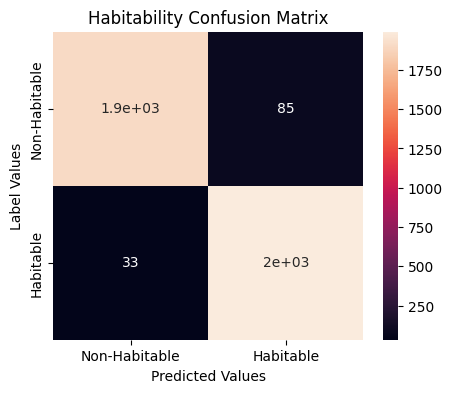

XGBoost Classififier - Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1990
           1       0.96      0.98      0.97      2026

    accuracy                           0.97      4016
   macro avg       0.97      0.97      0.97      4016
weighted avg       0.97      0.97      0.97      4016



In [57]:
# Train a XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=8,
                               max_depth=5,
                               learning_rate=1,
                               objective='binary:logistic',
                               eval_metric='logloss',
                               max_leaves=11)
xgb_classifier.fit(features_train, labels_train)

# Predict the samples in the test subset
xgb_classifier_predictions = xgb_classifier.predict(features_test)

# Plot the confusion matrix and print out the classification evaluation report
xgb_classifier_accuracy = accuracy_score(labels_test, xgb_classifier_predictions)
xgb_classifier_confusion_matrix = plot_confusion_matrix(labels_test, xgb_classifier_predictions)
print(f"XGBoost Classififier - Classification Report:\n")
print(classification_report(labels_test, xgb_classifier_predictions))

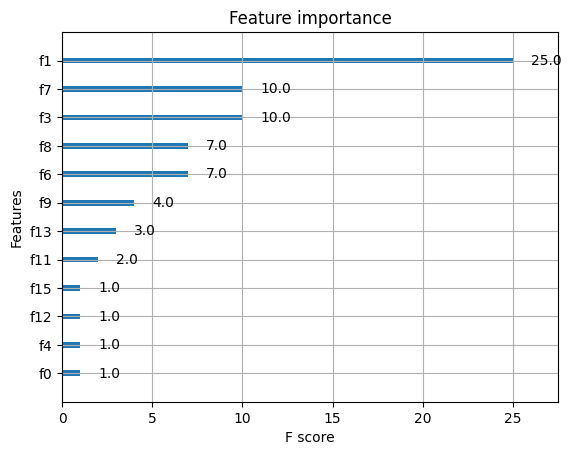

In [58]:
# Plot XGBoost classifier feature importance
plot_importance(xgb_classifier)
plt.show()

In [62]:
# Save the XGBoost classifier model
xgboost_pickle = open('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/xgboost_classifier', 'wb')
pickle.dump(xgb_classifier, xgboost_pickle)
xgboost_pickle.close()

In [63]:
# Load the XGBoost classifier model and test with test data
loaded_xgboost_classifier = pickle.load(open('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/GalaxiesPaper2024/HabitableExoplanetClassifiers/xgboost_classifier', 'rb'))
pred_results = loaded_xgboost_classifier.predict(features_test)
pred_results

array([1, 1, 0, ..., 0, 0, 0])